In [78]:
from __future__ import print_function

from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, GRU
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from keras import optimizers
import tensorflow as tf

In [79]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [2]:
nteams = 20
nmatches = (nteams-1)*2

In [3]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

Data Pre-processing

In [4]:
def season_team_map(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    return team_map

In [14]:
def season_team_map_div_2(season_dir):
    readme = season_dir + '/README.md'
    f = open(readme, 'r')
    
    s = "  "
    
    # skip to teams
    while(s[1] != '1'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "
            
    s = f.readline()
    if(len(s)<=1):
        s = "  "    
        
     # skip to div 2 teams
    while(s[:3] != ' 1.'):
        s = f.readline()
        if(len(s)<=1):
            s = "  "

    team_map = {}

    for i in range(20):
        team_map[s[4:].split('  ')[0]] = i
        s = f.readline()

    f.close()
    
    return team_map

In [8]:
def season_game_mat(season_dir, team_map, div=1):
    game_mat = np.zeros((nteams, nmatches), dtype=int)
    team_index = np.zeros(nteams, dtype=int)

    csvfile = ''
    
    for entry in os.scandir(season_dir):
        if(div==1):
            if '/1-' in entry.path:
                csvfile = entry.path
        elif(div==2):
            if '/2-' in entry.path:
                csvfile = entry.path
            
    with open(csvfile) as gf:
        reader = csv.reader(gf)
        header = next(reader)
        if(header[0] == 'Round'):
            new_format = 1
        else:
            new_format = 0;
        for row in reader:
            if(new_format):
                team1 = team_map[row[2].split(' (')[0]]
                team2 = team_map[row[5].split(' (')[0]]

                score = row[3].split('-')
            else:
                team1 = team_map[row[1]]
                team2 = team_map[row[2]]

                score = row[3].split('-')
            # 1 for win, 0 for draw, -1 for loss

            game_mat[team1, team_index[team1]] = int(score[0]) - int(score[1])
            game_mat[team2, team_index[team2]] = int(score[1]) - int(score[0])

            team_index[team1] += 1
            team_index[team2] += 1
    
    return np.transpose(game_mat)

In [15]:
country_dirs = []
season_dirs = []

nseasons = 0
team_maps = []
game_mats = []

for entry in os.scandir('./data'):
    if entry.is_dir():
        country_dirs.append(entry.path)

for cdir in country_dirs:
    for entry in os.scandir(cdir):
        if entry.is_dir():
            season_dir = entry.path
            team_maps.append(season_team_map(season_dir))
            game_mats.append(season_game_mat(season_dir, team_maps[nseasons]))
            nseasons += 1
            if(cdir=='./data/fr-france-master' and int(entry.name.split('-')[0])>=2002):
                team_maps.append(season_team_map_div_2(season_dir))
                game_mats.append(season_game_mat(season_dir, team_maps[nseasons], div=2))
                nseasons += 1

In [16]:
def eucl_error(outputs, targets):
    return np.mean(np.abs(targets - outputs))

In [17]:
def ternarize(x):
    if(x > 0.5):
        return 1
    if(x < -0.5):
        return -1
    return 0

def disc_error(outputs, targets):
    ternarize_fn = np.vectorize(ternarize)
    ternarized_outputs = ternarize_fn(np.round(outputs))
    ternarized_targets = ternarize_fn(np.round(targets))
    err = 0
    n = 0
    for i in range(len(outputs)):
        for j in range(len(outputs[i])):
            if(int(ternarized_outputs[i][j]) != int(ternarized_targets[i][j])):
                err += 1
            n += 1
    return float(err)/n

In [19]:
ntraining = int(nseasons*0.7)
ntesting = nseasons - ntraining

training_game_mats = game_mats[:ntraining]
testing_game_mats = game_mats[ntesting:]

X_training = np.reshape(np.array(training_game_mats), (ntraining*nmatches, nteams))
lengths = np.full(ntraining, nmatches)

In [20]:
nseasons

88

In [21]:
ntraining

61

In [45]:
Xs = []
Ys = []
for i in range(1, nmatches):
    X = []
    Y = []
    for game_mat in game_mats:
        for j in range(nmatches-i):
            X.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y.append(game_mat[j+i])
    
    X = np.array(X).reshape(-1,i,nteams)
    Y = np.array(Y).reshape(-1,nteams)
    Xs.append(X)
    Ys.append(Y)

In [22]:
X_trainings = []
Y_trainings = []
for i in range(1, nmatches):
    X_training = []
    Y_training = []
    for game_mat in training_game_mats:
        for j in range(nmatches-i):
            X_training.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_training.append(game_mat[j+i])
    
    X_training = np.array(X_training).reshape(-1,i,nteams)
    Y_training = np.array(Y_training).reshape(-1,nteams)
    X_trainings.append(X_training)
    Y_trainings.append(Y_training)

In [23]:
X_testings = []
Y_testings = []
for i in range(1, nmatches):
    X_testing = []
    Y_testing = []
    for game_mat in testing_game_mats:
        for j in range(nmatches-i):
            X_testing.append(np.ndarray.flatten(game_mat[j:j+i]))
            Y_testing.append(game_mat[j+i])
            
    X_testing = np.array(X_testing).reshape(-1,i,nteams)
    Y_testing = np.array(Y_testing).reshape(-1,nteams)
    X_testings.append(X_testing)
    Y_testings.append(Y_testing)

In [24]:
layer_sizes = [200]

In [25]:
rnns = {}
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    rnns[key] = []

In [26]:
histories = {}
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    histories[key] = []

In [68]:
epochs = 20
max_sequence_length = 10
size = 200

In [75]:
model = Sequential()
model.add(GRU(size, input_shape=(8, nteams), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(size))
model.add(Dropout(0.2))
#model.add(Dense(nteams, activation='softmax'))
model.add(Dense(nteams, activation='tanh'))
opt = optimizers.Adam(lr=0.001)
model.compile(loss='mean_squared_error', optimizer=opt)
history = model.fit(X_trainings[7], np.array(Y_trainings[7]), batch_size=10, epochs=10)

Epoch 1/10
1830/1830 [==============================] - 7s 4ms/step - loss: 2.6990
Epoch 2/10
1830/1830 [==============================] - 4s 2ms/step - loss: 2.6448
Epoch 3/10
1830/1830 [==============================] - 4s 2ms/step - loss: 2.6135A: 3s - loss:
Epoch 4/10
1830/1830 [==============================] - 4s 2ms/step - loss: 2.5735
Epoch 5/10
1830/1830 [==============================] - 4s 2ms/step - loss: 2.5184
Epoch 6/10
1830/1830 [==============================] - 4s 2ms/step - loss: 2.4355
Epoch 7/10
1830/1830 [==============================] - 4s 2ms/step - loss: 2.3279
Epoch 8/10
1830/1830 [==============================] - 5s 2ms/step - loss: 2.2167
Epoch 9/10
1830/1830 [==============================] - 4s 2ms/step - loss: 2.0981
Epoch 10/10
1830/1830 [==============================] - 4s 2ms/step - loss: 1.9921


In [76]:
output = model.predict(X_trainings[7])
tr_acc = 1 - disc_error(output, np.array(Y_trainings[7]))
tr_eerr = eucl_error(output, np.array(Y_trainings[7]))

output = model.predict(X_testings[7])
te_acc = 1 - disc_error(output, np.array(Y_testings[7]))
te_eerr = eucl_error(output, np.array(Y_testings[7]))

In [77]:
print(tr_acc, tr_eerr, te_acc, te_eerr)

0.6188524590163935 1.00598396692 0.5290437158469945 1.18390556904


In [74]:
print(history.history.keys())

dict_keys(['loss'])


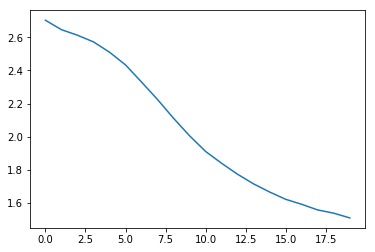

In [67]:
plt.plot(history.history['loss'])
plt.show()

In [28]:
for i in range(max_sequence_length):
    print("")
    print("Sequence Length of " + str(i))
    for size in layer_sizes:
        key = str(size)+'_neuron_layers'       
        # define the LSTM model
        model = Sequential()
        model.add(LSTM(size, input_shape=(i+1, nteams)))
        model.add(Dropout(0.2))
        #model.add(Dense(nteams, activation='softmax'))
        model.add(Dense(nteams, activation='tanh'))
        #model.compile(loss='categorical_crossentropy', optimizer='adam')
        model.compile(loss='mean_squared_error', optimizer='adam')
        histories[key].append(model.fit(X_trainings[i], np.array(Y_trainings[i]), epochs=epochs))
        rnns[key].append(model)

Epoch 1/20
2257/2257 [==============================] - 2s 758us/step - loss: 2.7499
Epoch 2/20
2257/2257 [==============================] - 1s 368us/step - loss: 2.6384
Epoch 3/20
2257/2257 [==============================] - 0s 203us/step - loss: 2.6140
Epoch 4/20
2257/2257 [==============================] - 1s 255us/step - loss: 2.6019
Epoch 5/20
2257/2257 [==============================] - 1s 374us/step - loss: 2.5915
Epoch 6/20
2257/2257 [==============================] - 0s 192us/step - loss: 2.5844
Epoch 7/20
2257/2257 [==============================] - 0s 215us/step - loss: 2.5798
Epoch 8/20
2257/2257 [==============================] - 0s 189us/step - loss: 2.5688
Epoch 9/20
2257/2257 [==============================] - 1s 246us/step - loss: 2.5665
Epoch 10/20
2257/2257 [==============================] - 0s 195us/step - loss: 2.5572
Epoch 11/20
2257/2257 [==============================] - 0s 194us/step - loss: 2.5498
Epoch 12/20
2257/2257 [==============================] - 0s 202

2013/2013 [==============================] - 1s 451us/step - loss: 2.0560
Epoch 17/20
2013/2013 [==============================] - 1s 455us/step - loss: 2.0005
Epoch 18/20
2013/2013 [==============================] - 1s 489us/step - loss: 1.9549
Epoch 19/20
2013/2013 [==============================] - 1s 534us/step - loss: 1.9045
Epoch 20/20
2013/2013 [==============================] - 1s 516us/step - loss: 1.8623
Epoch 1/20
1952/1952 [==============================] - 2s 1ms/step - loss: 2.6897
Epoch 2/20
1952/1952 [==============================] - 1s 451us/step - loss: 2.6295
Epoch 3/20
1952/1952 [==============================] - 1s 489us/step - loss: 2.6123
Epoch 4/20
1952/1952 [==============================] - 1s 567us/step - loss: 2.5904
Epoch 5/20
1952/1952 [==============================] - 1s 576us/step - loss: 2.5761
Epoch 6/20
1952/1952 [==============================] - 1s 596us/step - loss: 2.5553
Epoch 7/20
1952/1952 [==============================] - 1s 513us/step - lo

1708/1708 [==============================] - 2s 1ms/step - loss: 2.3273
Epoch 12/20
1708/1708 [==============================] - 2s 1ms/step - loss: 2.2686
Epoch 13/20
1708/1708 [==============================] - 2s 1ms/step - loss: 2.2124A: 1s - loss: 2 - ETA: 1s 
Epoch 14/20
1708/1708 [==============================] - 2s 896us/step - loss: 2.1540
Epoch 15/20
1708/1708 [==============================] - 2s 1ms/step - loss: 2.0873
Epoch 16/20
1708/1708 [==============================] - 2s 880us/step - loss: 2.0413
Epoch 17/20
1708/1708 [==============================] - 1s 870us/step - loss: 1.9791
Epoch 18/20
1708/1708 [==============================] - 2s 953us/step - loss: 1.9378
Epoch 19/20
1708/1708 [==============================] - 2s 1ms/step - loss: 1.8881
Epoch 20/20
1708/1708 [==============================] - 1s 810us/step - loss: 1.8524


In [29]:
def score(key):
    training_accs = []
    training_errs = []

    with open('rnn_nt_training_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("training")
        for i in range(max_sequence_length):
            print(i)
            outputs = rnns[key][i].predict(X_trainings[i])
            acc = 1 - disc_error(outputs, np.array(Y_trainings[i]))
            eerr = eucl_error(outputs, np.array(Y_trainings[i]))

            writer.writerow([i, acc, eerr])
            training_accs.append(acc)
            training_errs.append(eerr)
            
    testing_accs = []
    testing_errs = []

    with open('rnn_nt_testing_scores_' + key + '.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['Games before prediction', 'Accuracy', 'Euclidean Error'])
        print("testing")
        for i in range(max_sequence_length):
            print(i)
            outputs = rnns[key][i].predict(X_testings[i])
            acc = 1 - disc_error(outputs, np.array(Y_testings[i]))
            eerr = eucl_error(outputs, np.array(Y_testings[i]))

            writer.writerow([i, acc, eerr])
            testing_accs.append(acc)
            testing_errs.append(eerr)
    
    training_accs_dict[key] = training_accs
    training_errs_dict[key] = training_errs
    testing_accs_dict[key] = testing_accs
    testing_errs_dict[key] = testing_errs

In [30]:
training_accs_dict = {}
training_errs_dict = {}
testing_accs_dict = {}
testing_errs_dict = {}

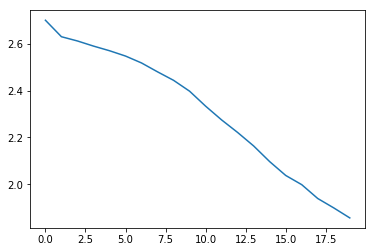

In [40]:
plt.plot(histories['200_neuron_layers'][7].history['loss'])
plt.show()

In [31]:
for size in layer_sizes:
    print(size)
    key = str(size)+'_neuron_layers'
    score(key)

200
training
0
1
2
3
4
5
6
7
8
9
testing
0
1
2
3
4
5
6
7
8
9


In [32]:
def plot(y, ylabel, title, imname, ylim):
    x = range(1,max_sequence_length+1)
    yfit = np.poly1d(np.polyfit(x, y, 1))(np.unique(x))
    r2 = np.round(r2_score(y, yfit),decimals=2)
    mean = np.round(np.mean(y), decimals=2)

    plt.scatter(x, y, s = 5)
    plt.plot(x, yfit)
    plt.axis([0,max_sequence_length+1,0,ylim])
    plt.text(1, 0.95, 'R^2: ' + str(r2))
    plt.text(1, 0.85, 'Mean: ' + str(mean))
    plt.xlabel('Games before prediction')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig('rnnntplots/' + imname + '.png')
    plt.show()

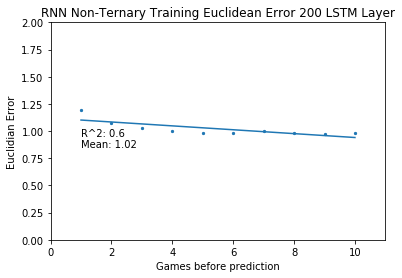

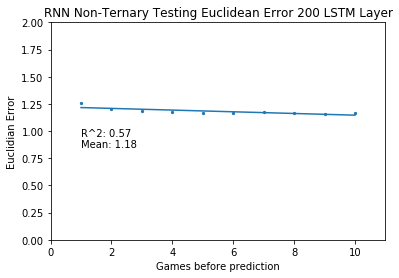

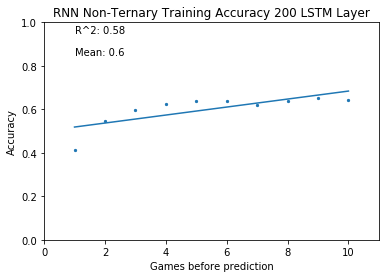

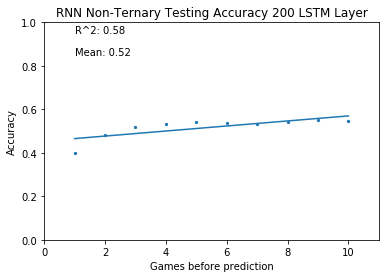

In [33]:
for size in layer_sizes:
    key = str(size)+'_neuron_layers'
    title = ' ' + str(size) + ' LSTM Layer'
    plot(training_errs_dict[key], 'Euclidian Error', 'RNN Non-Ternary Training Euclidean Error' + title, 'rnn_nt_training_error_plot_'+key, 2)
    plot(testing_errs_dict[key], 'Euclidian Error', 'RNN Non-Ternary Testing Euclidean Error' + title, 'rnn_nt_testing_error_plot_'+key, 2)
    plot(training_accs_dict[key], 'Accuracy', 'RNN Non-Ternary Training Accuracy' + title, 'rnn_nt_training_accuracy_plot_'+key, 1)
    plot(testing_accs_dict[key], 'Accuracy', 'RNN Non-Ternary Testing Accuracy' + title, 'rnn_nt_testing_accuracy_plot_'+key, 1)